# Prediction of solubility

Here we try to predict solubility of organic molecules just on basis of the chemical structure. Data was retrived from http://moleculenet.ai. Orginally the data was publiched by Delaney, John S. "ESOL: estimating aqueous solubility directly from molecular structure." Journal of chemical information and computer sciences 44.3 (2004): 1000-1005.

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.core.display import display
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('delaney-processed.csv')
df.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [3]:
df.shape

(1128, 10)

Let's see some example of structures presented in the data:

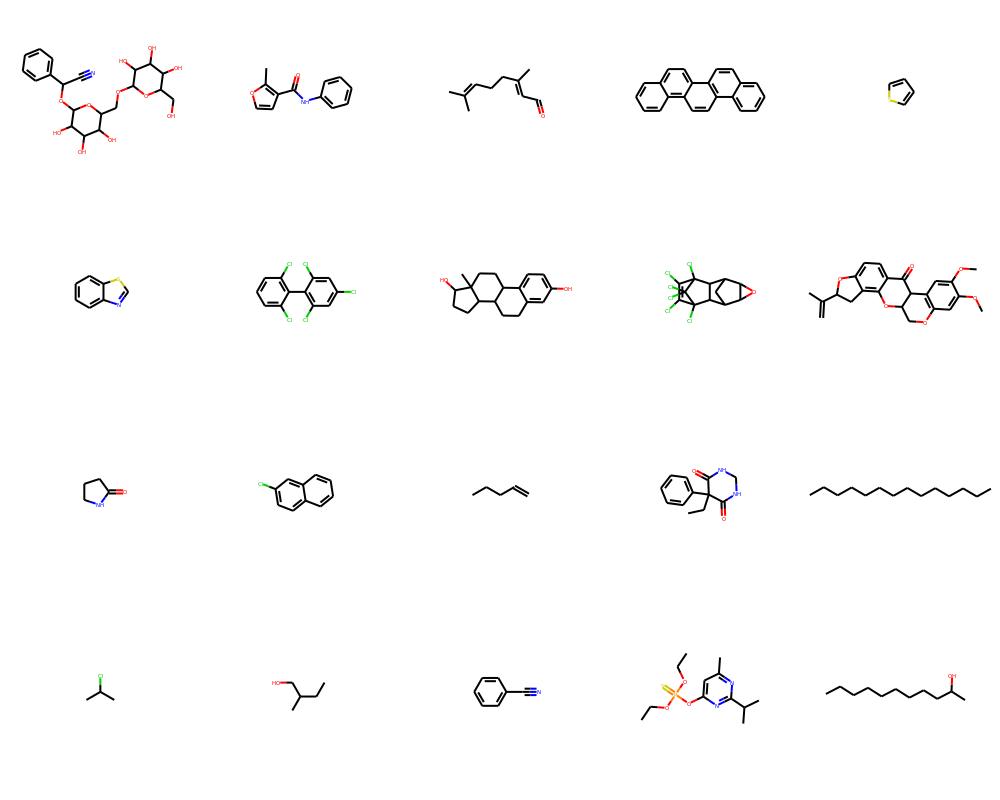

In [4]:
mols = [Chem.MolFromSmiles(df['smiles'].iloc[i]) for i in range(df.shape[0])]
Chem.Draw.MolsToGridImage(mols[:20], molsPerRow=5)

Evaluation of ELOS model. Since prediction of the model is the regression, the best choice is r2_score for evaluating the results. 

In [5]:
r2_score(df['measured log solubility in mols per litre'], df['ESOL predicted log solubility in mols per litre'])

0.8113621507764678

Pretty good! Let's now try improve this score.

Let's create firstly descriton of the molecules. Pretty often used fingerpret is EPCF, which recently was used for nice application in machine learning:

In [6]:
X = []
for mol in mols:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    X.append(arr)
X = np.array(X)

In [7]:
y = df['measured log solubility in mols per litre']

Now, we have data ready we can use some ML algorithm. I like in particular Random Forest becasue it is simple.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [10]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, max_features='sqrt').fit(X_train, y_train)

And the score:

In [11]:
clf.score(X_test, y_test)

0.6893287230762319

This seems like good result. Not as good as the ELOS, but it is good start!

### Murcko train-test split
However, above alogrithm could be critized becasue te data is limited (only over thousend of measurment) and might just identify similar molecules and give them average results. One of the strategies to prevent that is to do train-test split of different categories of the data. We could for example categorize molecules by their scaffold and create test set that scaffolds are not included in training test. (the idea is part of module deepchem.io, but I decided to implement it in python/sklearn to make it more transparent)

In [12]:
from rdkit.Chem.Scaffolds import MurckoScaffold

Let's create a list of scaffold existing in the data set:

In [13]:

scaffolds= {}
y = np.array(df['measured log solubility in mols per litre'])

scaffolds[MurckoScaffold.MakeScaffoldGeneric(MurckoScaffold.GetScaffoldForMol(mols[0]))]=[(mols[0],y[0])]

for n_mol in range(1,len(mols)):
    # generic scaffold
    #core = MurckoScaffold.MakeScaffoldGeneric(MurckoScaffold.GetScaffoldForMol(mol))
    mol = mols[n_mol]
    core = MurckoScaffold.GetScaffoldForMol(mol)
    #invariant for atoms
    fp_core = AllChem.GetMorganFingerprint(core,2)#,invariants=[1]*core.GetNumAtoms())
    
    already_scaffold = False
    
    # let's search if the scaffold already exist in the dictionary:
    for scaffold in scaffolds:
        fp_scaffold =AllChem.GetMorganFingerprint(scaffold,2)#,invariants=[1]*scaffold.GetNumAtoms())
        if fp_core == fp_scaffold:
            already_scaffold=True
            scaffolds[scaffold].append((mol, y[n_mol]))
    # we have not found the scaffold? Let's add new to the dictionary:
    if already_scaffold==False:
        scaffolds[core]=[(mol,y[n_mol])]
print(len(scaffolds))

269


In result our data can be categories on 269 different categories. Let's show some of the categories (only one which has more than 10 molecules, and show maximum 9 molecules (+1 scaffold)). First structure shows scaffold and it is followed by exact molecules.

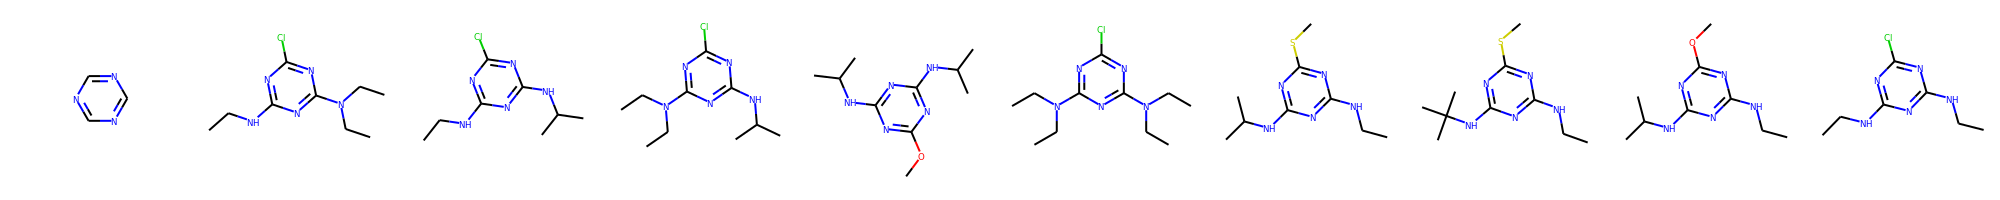

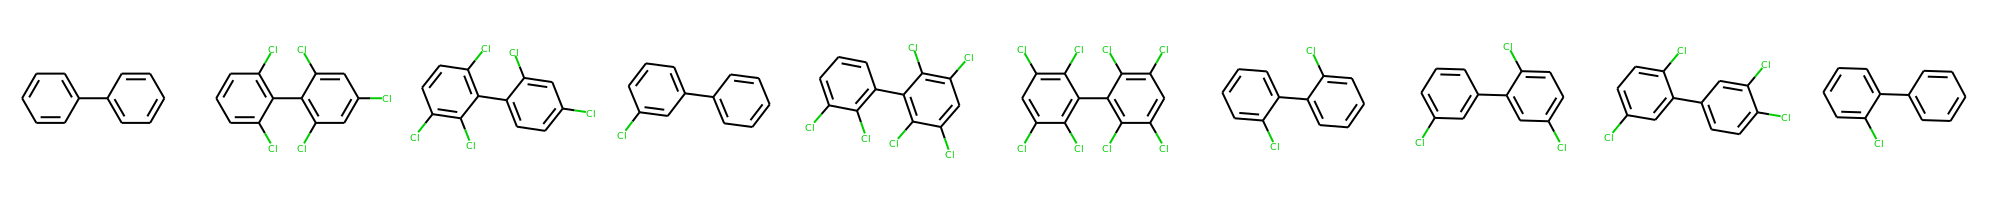

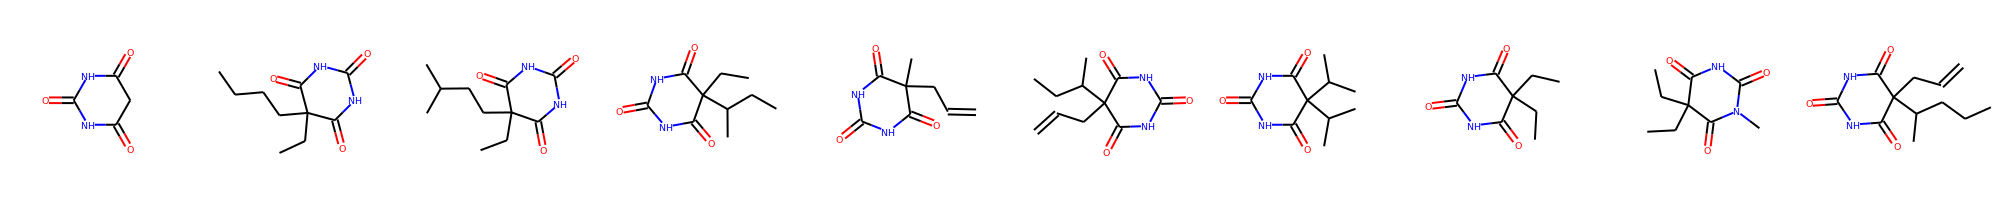

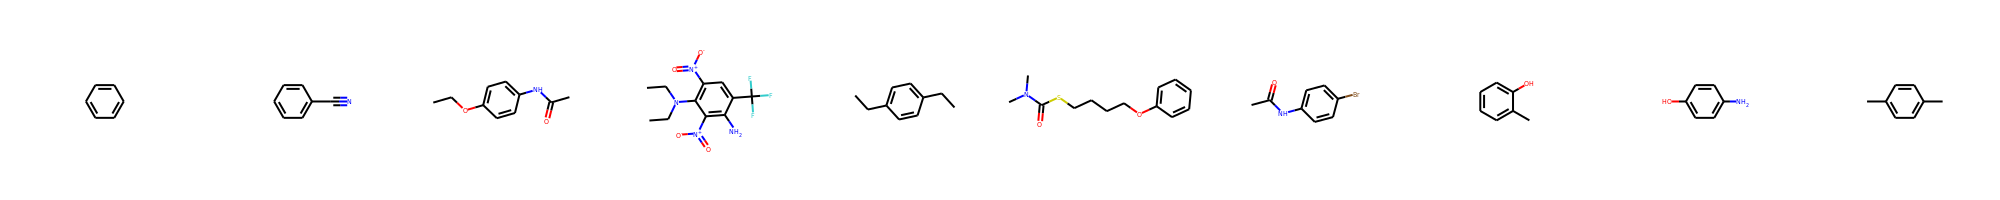

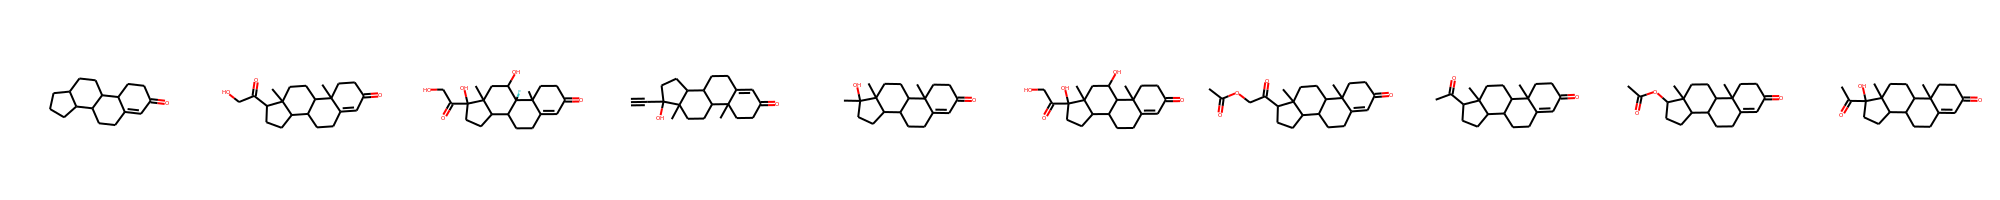

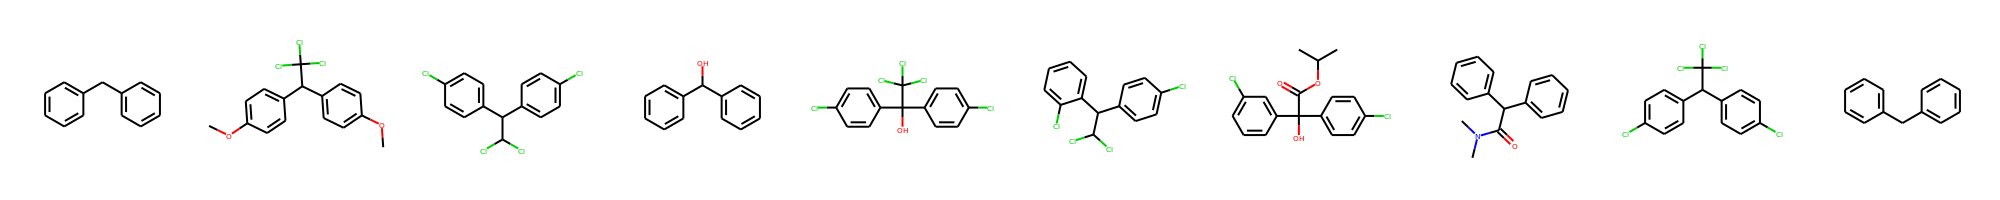

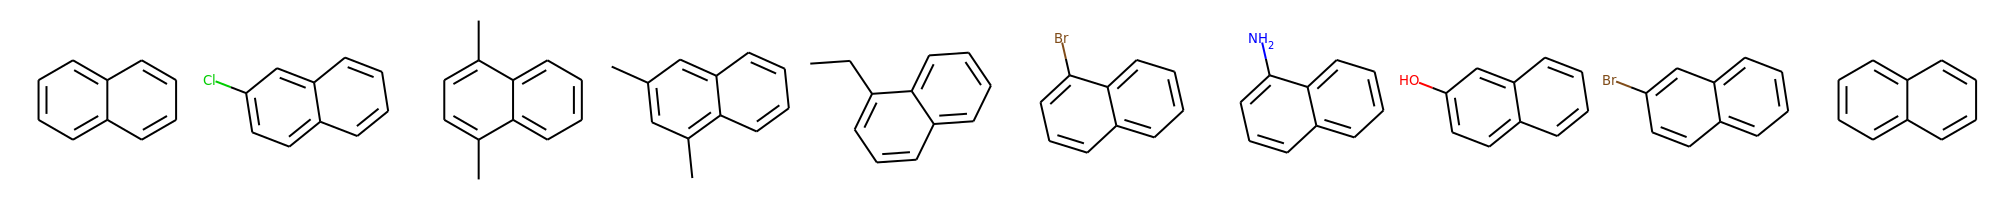

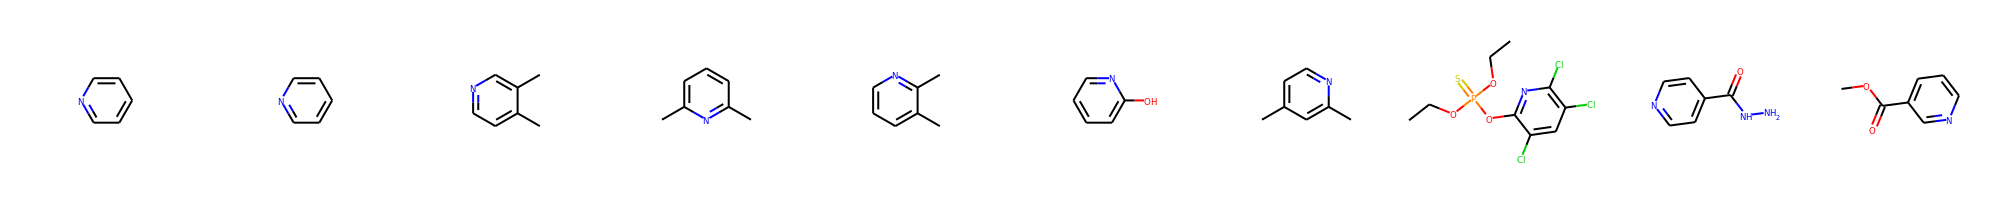

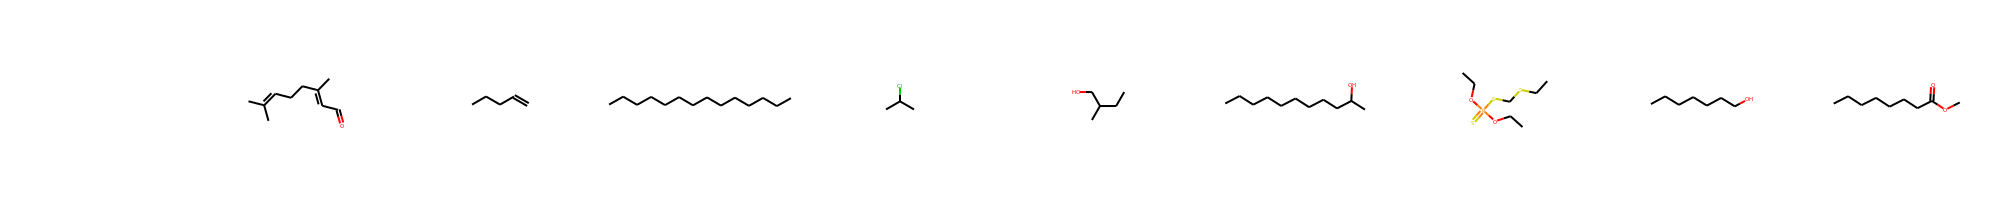

In [14]:
for scaffold in scaffolds:
    if len(scaffolds[scaffold])>10:
        #print(len(scaffolds[scaffold]))
        selected = [scaffold]+list(np.array(scaffolds[scaffold])[:,0])
        display(Chem.Draw.MolsToGridImage(selected[:10],molsPerRow=10))

Is the solubility depending on the scaffold? Lets plot distribution of some of the scaffolds

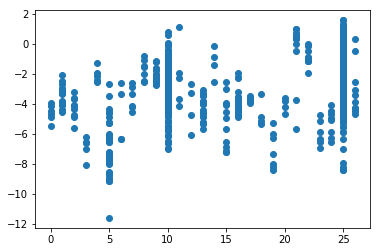

In [15]:
a = 0
x_e = []
y_e = []

for scaffold in scaffolds:
    temp = list(np.array(scaffolds[scaffold])[:,1])
    if len(temp)>3:
        y_e += temp
        x_e += [a]*len(temp)
        a+=1
           
plt.figure()            
plt.plot(x_e, y_e,'o')

Oh, yes. It seems that if we know the scaffold we can estimate fairly what is the solubility of the molecules. 

Let's tain-test split results again and change to fingerprints:

In [16]:
test_size = 0.25
test_len = int(len(mols)*0.25)

size = 0
#np.random.seed(10)
keys=scaffolds.keys()[:]
np.random.shuffle(keys)

X_test = []
X_train = []

y_test = []
y_train = []

for scaffold in keys:
    if size < test_len:
        #change to fingerprints:
        for mol in list(np.array(scaffolds[scaffold])[:,0]):
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,2)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            X_test.append(arr)            

        y_test+=list(np.array(scaffolds[scaffold])[:,1])
        size+=len(scaffolds[scaffold])
    else:
        for mol in list(np.array(scaffolds[scaffold])[:,0]):
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,2)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            X_train.append(arr) 
            
        y_train+=list(np.array(scaffolds[scaffold])[:,1])
        

In [17]:
from sklearn.dummy import DummyRegressor

In [18]:
dummy = DummyRegressor(strategy='mean').fit(X_train,y_train)
(dummy.score(X_train, y_train),dummy.score(X_test, y_test))

(0.0, -0.618077346144875)

In [19]:
clf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)

In [20]:
(clf.score(X_train, y_train),clf.score(X_test, y_test))

(0.9569041619604731, -0.3034373751696722)

This result is far from the ELOS aglorith, but  still little better then the just guessing the mean. For now then the most important part of the prediction is scaffold. Let's see how the scatter plots of both look like. 

The diffrence between scores for train set and for test set's imply that the model is overfitting. We have to validate model once again.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

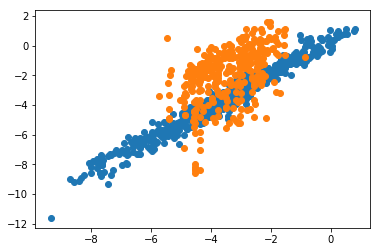

In [22]:
#ax1 = plt.subplot(121)
plt.scatter(clf.predict(X_train), y_train)
plt.scatter(clf.predict(X_test), y_test)

### Grid Search
Firstly let's try to find better results by grid search

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
clf = RandomForestRegressor()
param_grid = {'n_estimators': [2,8,64,256], 'max_features' : ['log2', 'sqrt','auto']}#, 'max_depth': [None, 4,16,64,256,1024]}
# This means that there is 3-fold cross validation:b
grid = GridSearchCV(clf, param_grid=param_grid,verbose=100,cv=3)

In [25]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] max_features=log2, n_estimators=2 ...............................
[CV]  max_features=log2, n_estimators=2, score=-3.06675762233, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] max_features=log2, n_estimators=2 ...............................
[CV]  max_features=log2, n_estimators=2, score=-0.062949897392, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] max_features=log2, n_estimators=2 ...............................
[CV]  max_features=log2, n_estimators=2, score=-0.022103981832, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[CV] max_features=log2, n_estimators=8 ...............................
[CV]  max_features=log2, n_estimators=8, score=-0.819469111157, total=   0.0s
[Parallel(n_jobs=1)]: D

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [2, 8, 64, 256], 'max_features': ['log2', 'sqrt', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=100)

In [26]:
grid.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=256, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [27]:
 (grid.best_score_ , grid.score(X_test, y_test), grid.best_params_)

(0.08824329936299721,
 -0.2768230089028709,
 {'max_features': 'log2', 'n_estimators': 256})

There is definitly an improvement, but a lot can be still done.

### Grid search with custom cross validation splitter
Let's firstly create simple splitter. All scaffolds has their own category

In [28]:
test_size = 0.25
test_len = int(len(mols)*0.25)

size = 0
np.random.seed(10)
keys=scaffolds.keys()[:]
np.random.shuffle(keys)

X_test = []
X_train = []

y_test = []
y_train = []

groups = []
group = 0

for scaffold in keys:
    if size < test_len:
        
        for mol in list(np.array(scaffolds[scaffold])[:,0]):
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,2)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            X_test.append(arr)            

        y_test+=list(np.array(scaffolds[scaffold])[:,1])
        size+=len(scaffolds[scaffold])
    else:
        for mol in list(np.array(scaffolds[scaffold])[:,0]):
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,2)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            X_train.append(arr) 
            
        y_train+=list(np.array(scaffolds[scaffold])[:,1])
        
        groups+=[group]*len(scaffolds[scaffold])
        group+=1
        
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)


In [29]:
from sklearn.model_selection import LeaveOneGroupOut

In [30]:
logo = LeaveOneGroupOut().split(X_train, y_train, groups=groups)

In [31]:
clf = RandomForestRegressor()
param_grid = {'n_estimators': [2,8,64], 'max_features' : ['log2', 'sqrt','auto']}#, 'max_depth': [None, 4,16,64,256,1024]}
# This means that there is 3-fold cross validation:b
grid = GridSearchCV(clf, param_grid=param_grid,verbose=1,cv=logo)
grid.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1188 out of 1188 | elapsed: 23.2min finished


Fitting 132 folds for each of 9 candidates, totalling 1188 fits


/home/piskorz/Programs/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=<generator object split at 0x7f88fc3132d0>,
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [2, 8, 64], 'max_features': ['log2', 'sqrt', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [32]:
(grid.best_score_ , grid.score(X_test, y_test), grid.best_params_)

(-4.208869963453095,
 -0.14500145102355355,
 {'max_features': 'log2', 'n_estimators': 8})

This low score probably is a result that now the esmiator is biased towords smaller chemical groups. Single tree for the train test with single element (single molecule with particular scaffold) now is as important as tree with many elements (many molecules with the same scaffold).

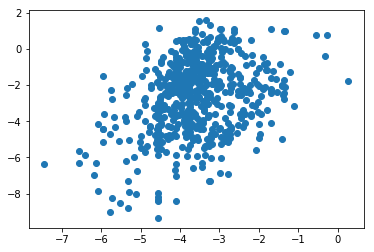

In [33]:
plt.scatter(grid.predict(X_test), y_test)

### Grid Search with custom cateogry splitter (but categories with only one element are grouped)

In [34]:
test_size = 0.25
test_len = int(len(mols)*0.25)

size = 0
np.random.seed(10)
keys=scaffolds.keys()[:]
np.random.shuffle(keys)

X_test = []
X_train = []

y_test = []
y_train = []

groups = []
group = 1

for scaffold in keys:
    if size < test_len:
        
        for mol in list(np.array(scaffolds[scaffold])[:,0]):
            fp = AllChem.GetMorganFingerprintAsBitVect(mol,2)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            X_test.append(arr)            

        y_test+=list(np.array(scaffolds[scaffold])[:,1])
        size+=len(scaffolds[scaffold])
    else:
        if len(scaffolds[scaffold])>1:
            for mol in list(np.array(scaffolds[scaffold])[:,0]):
                fp = AllChem.GetMorganFingerprintAsBitVect(mol,2)
                arr = np.zeros((1,))
                DataStructs.ConvertToNumpyArray(fp, arr)
                X_train.append(arr) 

            y_train+=list(np.array(scaffolds[scaffold])[:,1])

            groups+=[group]*len(scaffolds[scaffold])
            group+=1
        else:
            for mol in list(np.array(scaffolds[scaffold])[:,0]):
                fp = AllChem.GetMorganFingerprintAsBitVect(mol,2)
                arr = np.zeros((1,))
                DataStructs.ConvertToNumpyArray(fp, arr)
                X_train.append(arr) 

            y_train+=list(np.array(scaffolds[scaffold])[:,1])
            groups+=[0]
            
X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [35]:
logo = LeaveOneGroupOut().split(X_train, y_train, groups=groups)

In [36]:
clf = RandomForestRegressor()
param_grid = {'n_estimators': [2,8,64], 'max_features' : ['log2', 'sqrt','auto']}#, 'max_depth': [None, 4,16,64,256,1024]}
# This means that there is 3-fold cross validation:b
grid = GridSearchCV(clf, param_grid=param_grid,verbose=1,cv=logo)
grid.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 333 out of 333 | elapsed:  2.3min finished


Fitting 37 folds for each of 9 candidates, totalling 333 fits


/home/piskorz/Programs/miniconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=<generator object split at 0x7f88f93d9d20>,
       error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [2, 8, 64], 'max_features': ['log2', 'sqrt', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [37]:
(grid.best_score_ , grid.score(X_test, y_test), grid.best_params_)

(-5.634468953689906,
 0.19008956874653116,
 {'max_features': 'log2', 'n_estimators': 64})

Definitly improvemnt. Probably categories has to be splitted more evenly.

# Neural network

In [38]:
from sklearn.neural_network import MLPRegressor

In [39]:
clf = MLPRegressor(hidden_layer_sizes=[256,64,16,8], max_iter=1000).fit(X_train, y_train)

In [40]:
(clf.score(X_train, y_train), clf.score(X_test, y_test))

(0.9986834294469394, 0.4688390569976115)

That was simple improvement

## Adding QSAR methodology

In [41]:
from mordred import Calculator, descriptors